In [30]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [31]:
!pip install --upgrade tensorflow keras


In [39]:
import tensorflow as tf
# Montar Google Drive
drive.mount('/content/drive')

model_classifier = load_model('/content/drive/MyDrive/TFG CODE/classifier_model.h5')
model_detector = load_model('/content/drive/MyDrive/TFG CODE/identifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

data = []
labels = []
classes = 2
cur_path = os.getcwd()

In [34]:
classes_ident = { 0:'No signal', 1:'Signal'}

classes_classifier = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

# MAIN ALGORITHM

Class: Yield, Confidence: 99.58%


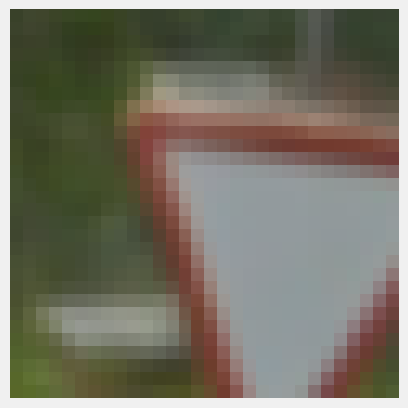

Yield
Class: Yield, Confidence: 99.96%


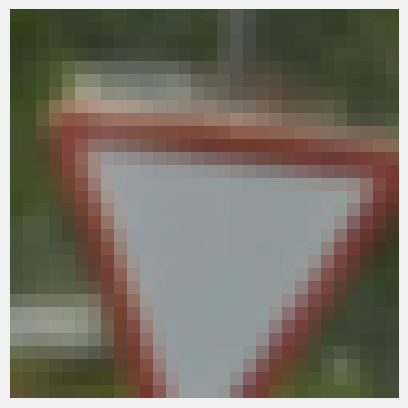

Yield
Class: Yield, Confidence: 99.97%


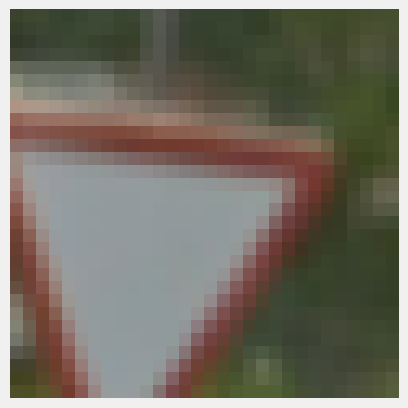

Yield
Class: No passing, Confidence: 50.79%
Class: Yield, Confidence: 100.00%


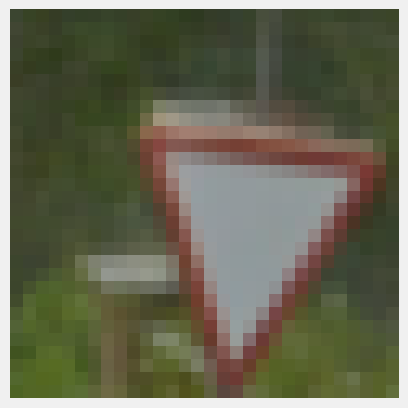

Yield
Class: Yield, Confidence: 100.00%


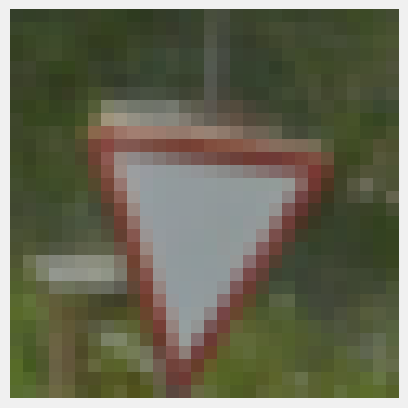

Yield


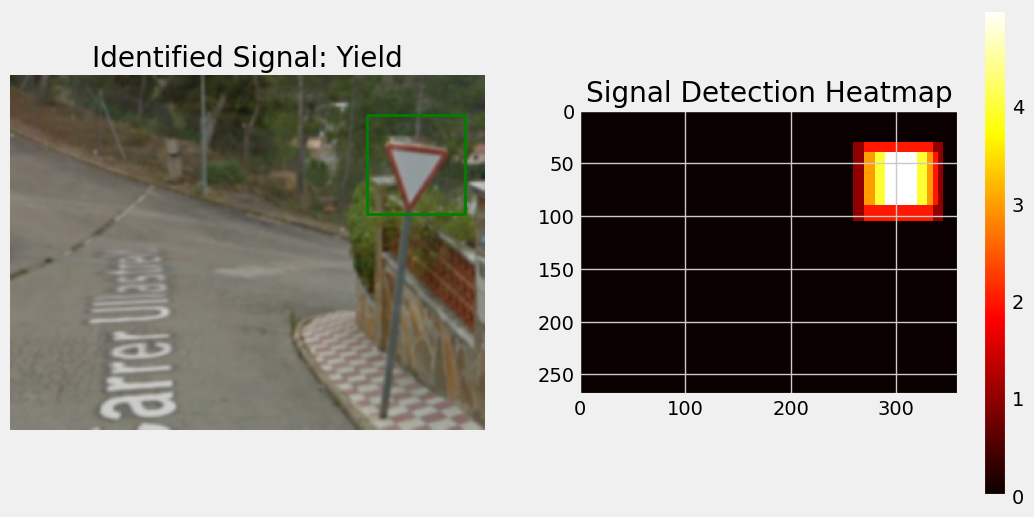

In [40]:
# Parameters
step_size = 10
window_sizes = [(50, 50), (75, 75), (100, 100)]
nms_threshold = 0.3
detector_confidence_threshold = 0.7
classifier_confidence_threshold = 0.99

Final_decisions = []

# Load the image
image_path = '/content/drive/MyDrive/TFG CODE/Test Images/maps/46.png'
image = cv2.imread(image_path)

# Process Images
image = cv2.resize(image, (360, 270))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.GaussianBlur(image, (5, 5), 0)
image = image / 255.0
image = np.expand_dims(image, axis=0)


# Function to perform sliding window object detection with different window sizes
def sliding_window(image, step_size, window_sizes):
    detected_rois = []
    heatmap = np.zeros((image.shape[1], image.shape[2]))
    confidences = []

    for window_size in window_sizes:
        # Slide a window across the image
        for y in range(0, image.shape[1] - window_size[1], step_size):
            for x in range(0, image.shape[2] - window_size[0], step_size):
                roi = image[0, y:y + window_size[1], x:x + window_size[0]]
                roi = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))
                roi = np.expand_dims(roi, axis=0)

                predictions = model_detector.predict(roi, verbose=0)
                predicted_class = np.argmax(predictions)
                label = classes_ident[predicted_class]
                confidence = predictions[0][1]

                # If the predicted label matches the object of interest, store the ROI
                if label == 'Signal' and confidence > detector_confidence_threshold:
                    predictions2 = model_classifier.predict(roi, verbose=0)
                    predicted_class2 = np.argmax(predictions2)
                    label2 = classes_classifier[predicted_class2]
                    confidence2 = predictions2[0][predicted_class2]

                    # Print the confidence percentage
                    print(f"Class: {label2}, Confidence: {confidence2 * 100:.2f}%")

                    if confidence2 > classifier_confidence_threshold:
                        detected_rois.append((x, y, x + window_size[0], y + window_size[1], confidence2))
                        confidences.append(confidence2)
                        heatmap[y:y + window_size[1], x:x + window_size[0]] += confidence2

                        plt.imshow(roi[0])
                        plt.axis('off')
                        plt.show()
                        print(label2)
                        Final_decisions.append(label2)

    return image[0], heatmap, detected_rois, confidences


def non_max_suppression(boxes, confidences, threshold):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    confidences = np.array(confidences)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = confidences.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h
        overlap = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(overlap <= threshold)[0]
        order = order[inds + 1]

    return keep



output_image, heatmap, detected_rois, confidences = sliding_window(image, step_size, window_sizes)

keep = non_max_suppression(detected_rois, confidences, nms_threshold)
nms_rois = [detected_rois[i] for i in keep]

count = Counter(Final_decisions)
Final_decision = count.most_common(1)

if len(nms_rois) == 0:
    print("No signals detected in the image.")
else:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(output_image)

    for roi in nms_rois:
        if len(roi) == 5:
            x1, y1, x2, y2, conf = roi
            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='green', linewidth=2)
    plt.axis('off')
    plt.title(f'Identified Signal: {Final_decision[0][0]}' if Final_decision else "No signals detected")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Signal Detection Heatmap')
    plt.show()

    for i, roi in enumerate(nms_rois):
        if len(roi) == 5:
            x1, y1, x2, y2, conf = roi
            roi_image = image[0, y1:y2, x1:x2]
            roi_image = (roi_image * 255).astype(np.uint8)
            cv2.imwrite(f'detected_roi_{i}.png', cv2.cvtColor(roi_image, cv2.COLOR_RGB2BGR))

